### Loading the data

In [1]:
import torch
from torchvision import transforms, datasets

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('F_MNIST_data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('F_MNIST_data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### defining the model

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
#         flattening the input tensor here, so that we can pass the image directly
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [3]:
model = Classifier()

images, labels = next(iter(testloader))

# checking the shape of class probabilities
ps = model(images)
print(ps.shape)

torch.Size([64, 10])


### Retrieving the class with highest probability

With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [4]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10, :])

tensor([[8],
        [9],
        [8],
        [8],
        [8],
        [9],
        [8],
        [8],
        [9],
        [9]])


---
After finding the predictions (top_class) we can equate it with original labels to find whether the predictions were correct or not.

---
` equals = top_class == labels ` would give us the necessary list of boolean values classifying the values as $correct-1$ an $incorrect-0$

---

In [5]:
equals = top_class == labels.view(*top_class.shape)
print(equals[:10])

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


### Calculating the Accuracy

In [6]:
# since equals contains all the boolean values,
# we must first convert it to floating point values,
# in order to calculate the mean

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy*100}%')

Accuracy: 4.6875%


### Implementing a Validation pass in a loop

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        
#         turning the gradients off for validation pass for saving memory and faster computation
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        test_losses.append(test_loss/len(testloader))
        train_losses.append(running_loss/len(trainloader))
        
        print('Epoch: {}/{}  '.format(e+1,epochs),
              'Training Loss: {:.4f}  '.format(running_loss/len(trainloader)),
              'Testing Loss: {:.4f}  '.format(test_loss/len(testloader)),
              'Test Accuracy: {:.4f}\n'.format(accuracy/len(testloader)))

Epoch: 1/30   Training Loss: 0.5121   Testing Loss: 0.4621   Test Accuracy: 0.8310

Epoch: 2/30   Training Loss: 0.3903   Testing Loss: 0.4446   Test Accuracy: 0.8381

Epoch: 3/30   Training Loss: 0.3557   Testing Loss: 0.3976   Test Accuracy: 0.8572

Epoch: 4/30   Training Loss: 0.3345   Testing Loss: 0.3757   Test Accuracy: 0.8656

Epoch: 5/30   Training Loss: 0.3130   Testing Loss: 0.3774   Test Accuracy: 0.8673

Epoch: 6/30   Training Loss: 0.3017   Testing Loss: 0.3819   Test Accuracy: 0.8667

Epoch: 7/30   Training Loss: 0.2929   Testing Loss: 0.3655   Test Accuracy: 0.8737

Epoch: 8/30   Training Loss: 0.2803   Testing Loss: 0.3808   Test Accuracy: 0.8645

Epoch: 9/30   Training Loss: 0.2737   Testing Loss: 0.3731   Test Accuracy: 0.8750

Epoch: 10/30   Training Loss: 0.2665   Testing Loss: 0.3524   Test Accuracy: 0.8767

Epoch: 11/30   Training Loss: 0.2607   Testing Loss: 0.3615   Test Accuracy: 0.8797

Epoch: 12/30   Training Loss: 0.2571   Testing Loss: 0.3521   Test Accurac

### Plotting the results

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

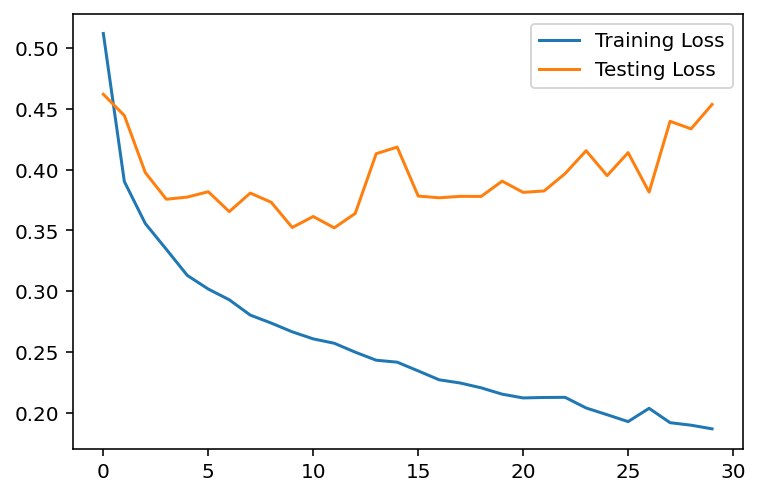

In [12]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend(frameon='False')

Overfitting has occurred